将数据处理成新的数据喂进模型，本次探索为第四大题和第五大题服务。根据数据建立模型:
目前比较流行得模型是以神经网络作为主流得机器学习模型，其中学术环境中测试最为有效的环境是CNN和LSTM
名字分别为，Convolutional Neural NetWork,Long Short Term Merrmory,前者能有效截取片段，后者的神经元具有记忆特性的优点，往往有文章将两者结合一起进行训练会有比较好的结果，但是本次由于时限原因，只采取<<Improving Deep Learning-Based UWB LOS/NLOS Identification with Transfer Learning:An Empirical Approach>>该文章。链接:https://www.mdpi.com/2079-9292/9/10/1714<br>
下面为本文的模型结构图:
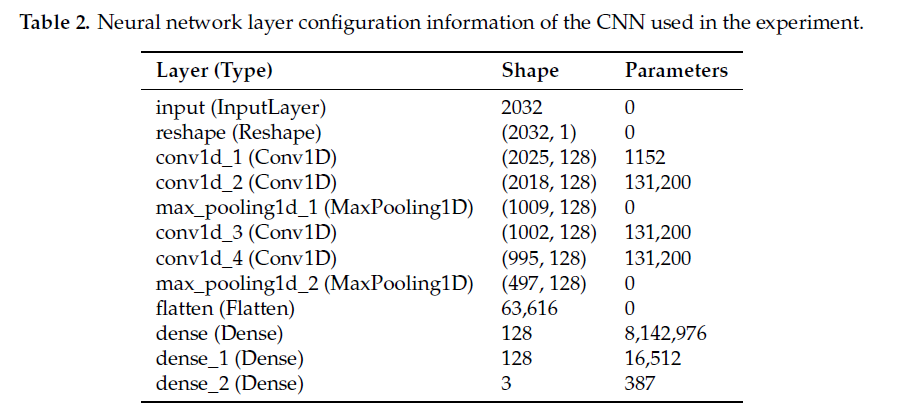
但是考虑本次实验的数据结构，模型的样式和维度会有稍微的变化


任务中对附件4的一个描述，说明了对数据点的处理是单个点的处理，及判断单个数据是否为在干扰情况下的数据，所以任务五的一个行文思路便是用优化好的模型去筛掉为干扰后的数据组，并进行删除，此时得到已经经过去除干扰且在之前经过数据清理的数据。<br>
值得注意的是本文的数据异常和正常处理有不同数量的数据组，所以为了平衡数据，在这里我们训练40%的干扰数据以及50%的未干扰数据。

In [24]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# class n_LOSnet(nn.Module):
#     def __init__(self , input_size , hidden_size):
#         super(neuralnet , self).__init__()
#         self.linear1 = nn.Linear(hidden_size  ,hidden_size)
#         self.relu = nn.relu()
#         self.linear2 = nn.Linear(hidden_size , 1)
#         self.softmax = nn.softmax()
        
#     def forward(self ,x):
#         x = self.relu(self.linear1(x))
#         x = self

In [1]:
import os
import pandas as pd
import numpy as np
# print(os.listdir())
los = pd.read_csv('处理后无干扰的数据.csv')
nlos = pd.read_csv('处理后有干扰的数据.csv')
print(los.head())
print(nlos.head())
print(f'干扰后数据有{len(nlos)} ,干扰后的数据有{len(los)}')

   Unnamed: 0  position1  position2  position3  position4  code
0           0      750.0     4550.0     4550.0     6300.0     1
1           1      750.0     4550.0     4560.0     6300.0     1
2           2      750.0     4540.0     4560.0     6310.0     1
3           3      780.0     4550.0     4550.0     6300.0     1
4           4      780.0     4550.0     4550.0     6310.0     1
   Unnamed: 0  position1  position2  position3  position4  code
0           0     1220.0     4550.0     4550.0     6290.0     1
1           1      750.0     5050.0     4540.0     6310.0     1
2           2     1290.0     4540.0     4540.0     6310.0     1
3           3      780.0     5010.0     4540.0     6300.0     1
4           4     1250.0     4550.0     4560.0     6290.0     1
干扰后数据有26979 ,干扰后的数据有22833


In [2]:
# 0表示为无干扰
los_= los[['position1'  ,'position2' , 'position3' , 'position4']]
los_['los/nlos'] = 0 
nlos_ = nlos[['position1'  ,'position2' , 'position3' , 'position4']]
nlos_['los/nlos'] = 1

<ipython-input-2-70b9511c0966>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  los_['los/nlos'] = 0
<ipython-input-2-70b9511c0966>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlos_['los/nlos'] = 1


In [3]:
los_.head()

,position1,position2,position3,position4,los/nlos
0,750.0,4550.0,4550.0,6300.0,0
1,750.0,4550.0,4560.0,6300.0,0
2,750.0,4540.0,4560.0,6310.0,0
3,780.0,4550.0,4550.0,6300.0,0
4,780.0,4550.0,4550.0,6310.0,0


In [4]:
nlos_.head()

,position1,position2,position3,position4,los/nlos
0,1220.0,4550.0,4550.0,6290.0,1
1,750.0,5050.0,4540.0,6310.0,1
2,1290.0,4540.0,4540.0,6310.0,1
3,780.0,5010.0,4540.0,6300.0,1
4,1250.0,4550.0,4560.0,6290.0,1


In [5]:
# los_.append(nlos_)
data = los_.append(nlos_)
len(data)

49812

In [6]:
from sklearn.preprocessing import StandardScaler , RobustScaler
rob = RobustScaler()
data_scaled = rob.fit_transform(data[['position1'  ,'position2' , 'position3' , 'position4']])
data_scaled

array([[-1.73513514,  0.3027027 ,  0.3027027 ,  1.24864865],
       [-1.73513514,  0.3027027 ,  0.30810811,  1.24864865],
       [-1.73513514,  0.2972973 ,  0.30810811,  1.25405405],
       ...,
       [-1.63783784,  0.04864865,  0.29189189,  1.33513514],
       [-1.38918919,  0.05405405,  0.28648649,  1.09189189],
       [-1.37297297,  0.05405405,  0.28648649,  1.08108108]])

In [7]:
data_scaled = pd.DataFrame(data_scaled)
station_p = np.array([0,0,1300,5000,0,1700,0,5000,1700,5000,5000,1300])/1000
data_scaled[['A01','A02','A03','A11','A12','A13','A21','A22','A23','A31','A32','A33']]=station_p
data_scaled.head()

,0,1,2,3,A01,A02,A03,A11,A12,A13,A21,A22,A23,A31,A32,A33
0,-1.735135,0.302703,0.302703,1.248649,0.0,0.0,1.3,5.0,0.0,1.7,0.0,5.0,1.7,5.0,5.0,1.3
1,-1.735135,0.302703,0.308108,1.248649,0.0,0.0,1.3,5.0,0.0,1.7,0.0,5.0,1.7,5.0,5.0,1.3
2,-1.735135,0.297297,0.308108,1.254054,0.0,0.0,1.3,5.0,0.0,1.7,0.0,5.0,1.7,5.0,5.0,1.3
3,-1.718919,0.302703,0.302703,1.248649,0.0,0.0,1.3,5.0,0.0,1.7,0.0,5.0,1.7,5.0,5.0,1.3
4,-1.718919,0.302703,0.302703,1.254054,0.0,0.0,1.3,5.0,0.0,1.7,0.0,5.0,1.7,5.0,5.0,1.3


In [8]:
data

,position1,position2,position3,position4,los/nlos
0,750.0,4550.0,4550.0,6300.0,0
1,750.0,4550.0,4560.0,6300.0,0
2,750.0,4540.0,4560.0,6310.0,0
3,780.0,4550.0,4550.0,6300.0,0
4,780.0,4550.0,4550.0,6310.0,0
...,...,...,...,...,...
26974,1390.0,4090.0,4530.0,5990.0,1
26975,930.0,4080.0,4520.0,6450.0,1
26976,930.0,4080.0,4530.0,6460.0,1
26977,1390.0,4090.0,4520.0,6010.0,1


In [14]:
import tensorflow as tf 
from tensorflow.keras import backend as b
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split

X = data_scaled.values
y = data['los/nlos']

x_train , x_test , y_train , y_test = train_test_split(X , y , train_size=0.8 )

n_inputs = x_train.shape[1]
model = Sequential([
    Dense(n_inputs , input_shape=(n_inputs, ) , activation = 'relu'),
    Dense(128 , activation = 'relu'),
    Dense(256 , activation = 'relu'),
    Dense(256 , activation = 'relu'),
    Dense(512 , activation = 'softmax')
])

In [15]:
model.compile(Adam(lr=0.001) , loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [16]:
his1 = model.fit(x_train , y_train , validation_split=0.2 ,  epochs=130 ,
          batch_size=64 ,shuffle=True , verbose=2
         )

Epoch 1/130
499/499 - 2s - loss: 0.7652 - accuracy: 0.5314 - val_loss: 0.6617 - val_accuracy: 0.6098
Epoch 2/130
499/499 - 2s - loss: 0.6050 - accuracy: 0.6637 - val_loss: 0.6822 - val_accuracy: 0.6304
Epoch 3/130
499/499 - 2s - loss: 0.4871 - accuracy: 0.7609 - val_loss: 0.4507 - val_accuracy: 0.7839
Epoch 4/130
499/499 - 2s - loss: 0.4423 - accuracy: 0.7813 - val_loss: 0.4181 - val_accuracy: 0.8015
Epoch 5/130
499/499 - 2s - loss: 0.4276 - accuracy: 0.7889 - val_loss: 0.4107 - val_accuracy: 0.7903
Epoch 6/130
499/499 - 2s - loss: 0.4134 - accuracy: 0.7927 - val_loss: 0.4154 - val_accuracy: 0.7934
Epoch 7/130
499/499 - 2s - loss: 0.4125 - accuracy: 0.7936 - val_loss: 0.3871 - val_accuracy: 0.8073
Epoch 8/130
499/499 - 2s - loss: 0.4050 - accuracy: 0.7986 - val_loss: 0.3889 - val_accuracy: 0.8055
Epoch 9/130
499/499 - 2s - loss: 0.4072 - accuracy: 0.7934 - val_loss: 0.3892 - val_accuracy: 0.8064
Epoch 10/130
499/499 - 2s - loss: 0.4002 - accuracy: 0.7978 - val_loss: 0.3857 - val_accura

Epoch 82/130
499/499 - 2s - loss: 0.1481 - accuracy: 0.9365 - val_loss: 0.1606 - val_accuracy: 0.9287
Epoch 83/130
499/499 - 2s - loss: 0.1382 - accuracy: 0.9407 - val_loss: 0.2541 - val_accuracy: 0.9029
Epoch 84/130
499/499 - 2s - loss: 0.1500 - accuracy: 0.9384 - val_loss: 0.1552 - val_accuracy: 0.9388
Epoch 85/130
499/499 - 2s - loss: 0.1408 - accuracy: 0.9421 - val_loss: 0.1524 - val_accuracy: 0.9370
Epoch 86/130
499/499 - 2s - loss: 0.1346 - accuracy: 0.9464 - val_loss: 0.1130 - val_accuracy: 0.9516
Epoch 87/130
499/499 - 2s - loss: 0.1347 - accuracy: 0.9450 - val_loss: 0.1200 - val_accuracy: 0.9552
Epoch 88/130
499/499 - 2s - loss: 0.1413 - accuracy: 0.9422 - val_loss: 0.1538 - val_accuracy: 0.9412
Epoch 89/130
499/499 - 2s - loss: 0.1232 - accuracy: 0.9504 - val_loss: 0.1165 - val_accuracy: 0.9578
Epoch 90/130
499/499 - 2s - loss: 0.1251 - accuracy: 0.9495 - val_loss: 0.1421 - val_accuracy: 0.9415
Epoch 91/130
499/499 - 2s - loss: 0.1403 - accuracy: 0.9433 - val_loss: 0.1218 - v

可以看出来，只用原始的数据我们达到了87%左右的一个正确率，此时我们加上灯塔的位置在模拟一次


In [33]:
# rob_base = RobustScaler()
# data_plus_station = data.copy()
# station_p = [0,0,1300,5000,0,1700,0,5000,1700,5000,5000,1300]
# data_plus_station[['A01','A02','A03','A11','A12','A13','A21','A22','A23','A31','A32','A33']]=station_p
# # data_scaled = rob.fit_transform(data[['position1'  ,'position2' , 'position3' , 'position4']])
# # data_scaled.


[0, 0, 1300, 5000, 0, 1700, 0, 5000, 1700, 5000, 5000, 1300]

In [17]:
model.compile(Adam(lr=0.0001) , loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])
his2 = model.fit(x_train , y_train , validation_split=0.2 ,  epochs=130 ,
          batch_size=64 ,shuffle=True , verbose=2
         )

Epoch 1/130
499/499 - 2s - loss: 0.0430 - accuracy: 0.9875 - val_loss: 0.0443 - val_accuracy: 0.9867
Epoch 2/130
499/499 - 2s - loss: 0.0403 - accuracy: 0.9887 - val_loss: 0.0435 - val_accuracy: 0.9883
Epoch 3/130
499/499 - 2s - loss: 0.0392 - accuracy: 0.9890 - val_loss: 0.0411 - val_accuracy: 0.9888
Epoch 4/130
499/499 - 2s - loss: 0.0380 - accuracy: 0.9897 - val_loss: 0.0416 - val_accuracy: 0.9868
Epoch 5/130
499/499 - 2s - loss: 0.0377 - accuracy: 0.9891 - val_loss: 0.0414 - val_accuracy: 0.9883
Epoch 6/130
499/499 - 2s - loss: 0.0371 - accuracy: 0.9894 - val_loss: 0.0412 - val_accuracy: 0.9856
Epoch 7/130
499/499 - 2s - loss: 0.0362 - accuracy: 0.9896 - val_loss: 0.0415 - val_accuracy: 0.9872
Epoch 8/130
499/499 - 2s - loss: 0.0360 - accuracy: 0.9894 - val_loss: 0.0415 - val_accuracy: 0.9887
Epoch 9/130
499/499 - 2s - loss: 0.0360 - accuracy: 0.9897 - val_loss: 0.0473 - val_accuracy: 0.9867
Epoch 10/130
499/499 - 2s - loss: 0.0352 - accuracy: 0.9901 - val_loss: 0.0409 - val_accura

Epoch 82/130
499/499 - 2s - loss: 0.0241 - accuracy: 0.9925 - val_loss: 0.0315 - val_accuracy: 0.9917
Epoch 83/130
499/499 - 2s - loss: 0.0239 - accuracy: 0.9928 - val_loss: 0.0323 - val_accuracy: 0.9911
Epoch 84/130
499/499 - 2s - loss: 0.0238 - accuracy: 0.9929 - val_loss: 0.0355 - val_accuracy: 0.9902
Epoch 85/130
499/499 - 2s - loss: 0.0238 - accuracy: 0.9928 - val_loss: 0.0325 - val_accuracy: 0.9905
Epoch 86/130
499/499 - 2s - loss: 0.0242 - accuracy: 0.9924 - val_loss: 0.0344 - val_accuracy: 0.9897
Epoch 87/130
499/499 - 2s - loss: 0.0246 - accuracy: 0.9921 - val_loss: 0.0323 - val_accuracy: 0.9905
Epoch 88/130
499/499 - 2s - loss: 0.0230 - accuracy: 0.9934 - val_loss: 0.0352 - val_accuracy: 0.9905
Epoch 89/130
499/499 - 2s - loss: 0.0239 - accuracy: 0.9926 - val_loss: 0.0344 - val_accuracy: 0.9912
Epoch 90/130
499/499 - 2s - loss: 0.0239 - accuracy: 0.9926 - val_loss: 0.0334 - val_accuracy: 0.9898
Epoch 91/130
499/499 - 2s - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.0359 - v

In [22]:
import seaborn as sns
a= his1.history['accuracy']
a1 =his2.history['accuracy']
a.extend(a1)
                                   
b = his1.history['val_accuracy']
b1 = his2.history['val_accuracy']
b.extend(b1)
a

[0.531384289264679,
 0.6636657118797302,
 0.7609084248542786,
 0.7813293933868408,
 0.7888892292976379,
 0.7926848530769348,
 0.7935945391654968,
 0.798582136631012,
 0.7934063076972961,
 0.7977665662765503,
 0.7971391677856445,
 0.802064061164856,
 0.8005897402763367,
 0.8031619787216187,
 0.8043539524078369,
 0.8095611333847046,
 0.806894838809967,
 0.8107531666755676,
 0.8143919110298157,
 0.8178738355636597,
 0.8227987289428711,
 0.8305153846740723,
 0.8351265788078308,
 0.8397377729415894,
 0.8442548513412476,
 0.8468897938728333,
 0.8487719297409058,
 0.8467329740524292,
 0.8572728037834167,
 0.8566768169403076,
 0.8597195744514465,
 0.854826033115387,
 0.8480190634727478,
 0.8492110967636108,
 0.8641111850738525,
 0.8638602495193481,
 0.8746196627616882,
 0.8771291375160217,
 0.8750901818275452,
 0.8881081342697144,
 0.8856614232063293,
 0.8891746997833252,
 0.889676570892334,
 0.8919978737831116,
 0.8795445561408997,
 0.89240562915802,
 0.902224063873291,
 0.8982715606689453,
 

In [31]:
print(len(a),len(b))

260 260


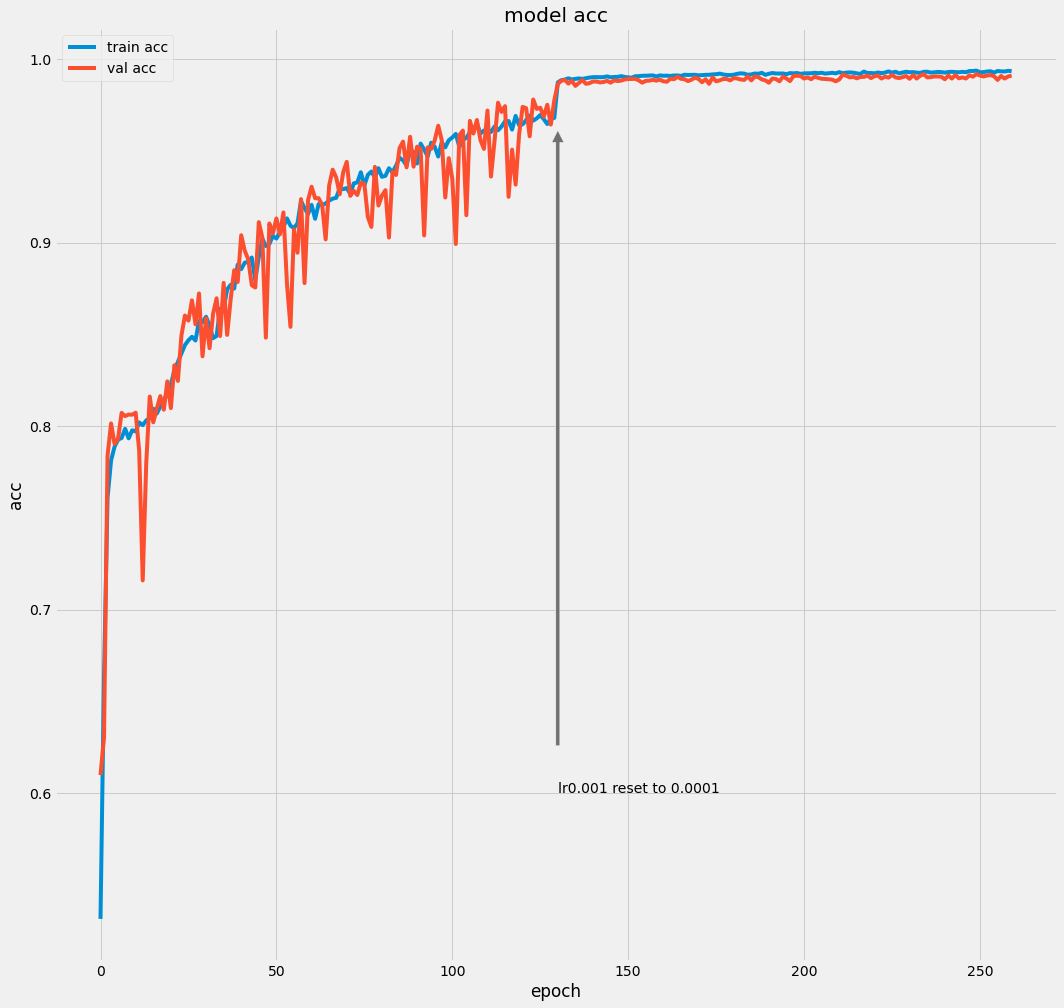

In [34]:

plt.style.use('fivethirtyeight')
plt.figure(figsize = (16,16))
plt.plot(a)
plt.plot(b)
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.annotate('lr0.001 reset to 0.0001', xy=(130, 0.98), xytext=(130, 0.6),
 arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.show()

In [40]:
model.save('Station_PositionPlus.h5')

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


C:\anaconda\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


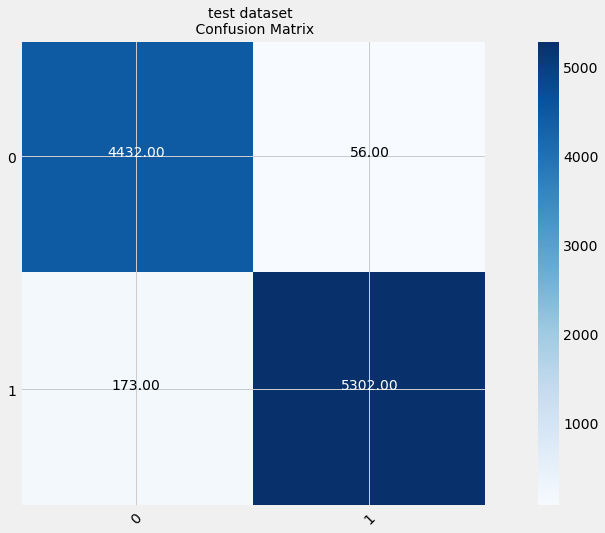

In [62]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
plt.style.use('fivethirtyeight')
# from sklearn.metrics import plot_confusion_matrix
predictions = model.predict_classes(x_test , batch_size=40 ,verbose = 0)
classes = [0,1]
cm = confusion_matrix(y_test, predictions)
fig = plt.figure(figsize=(16,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("test dataset \n Confusion Matrix", fontsize=14)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
normalize = True
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

In [67]:
accuracy = ((cm[0,0]+cm[1,1])/cm.sum())*100
print(f'在训练组的正确率{accuracy}%')

在训练组的正确率97.70149553347385%


# 很好
我们加入基站的数据作为一个辅助量，得出超乎想象的一个正确率，说明了基站的位置作为常量在检测信号是否干否有着非常重要的意义。

C:\anaconda\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


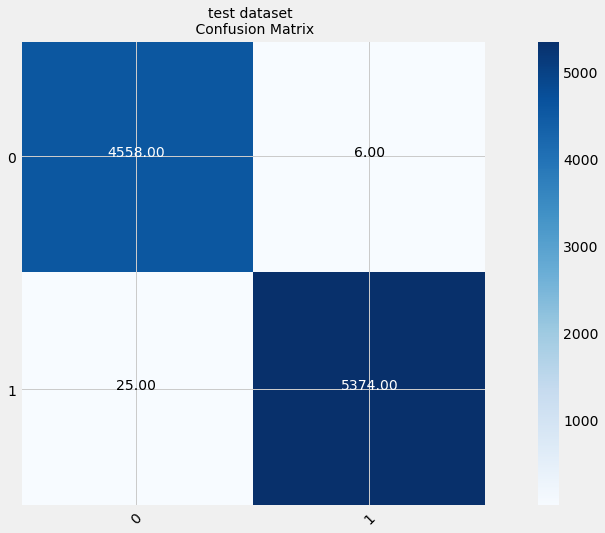

In [36]:
path = 'C:\\Users\\luzheng\\建模\\任务五核弹爆炸好模型\\'
classification = tf.keras.models.load_model(path+'第2次分类结果.h5')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
plt.style.use('fivethirtyeight')
# from sklearn.metrics import plot_confusion_matrix
predictions = classification.predict_classes(x_test , batch_size=40 ,verbose = 0)
classes = [0,1]
cm = confusion_matrix(y_test, predictions)
fig = plt.figure(figsize=(16,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("test dataset \n Confusion Matrix", fontsize=14)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
normalize = True
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

In [44]:
from sklearn.metrics import precision_score ,recall_score ,roc_auc_score , accuracy_score , f1_score ,classification_report

print('Recall Score: {:.4f}'.format(recall_score(y_train, classification.predict_classes(x_train))))
print('Precision Score: {:.4f}'.format(precision_score(y_train, classification.predict_classes(x_train))))
print('F1 Score: {:.4f}'.format(f1_score(y_train, classification.predict_classes(x_train))))
print('Accuracy Score: {:.4f}'.format(accuracy_score(y_train, classification.predict_classes(x_train))))


Recall Score: 0.9950
Precision Score: 0.9987
F1 Score: 0.9968
Accuracy Score: 0.9966
